In [39]:
import numpy as np
import matplotlib.pyplot as plt

from boost_histogram import Histogram
from boost_histogram.axis import Regular

import sys
sys.path.append('src')

from sts_sensor import StsSensor
from sts_track import StsTrack
from particle_gun import ParticleGun
from trajectories import *
from fitters import *

In [40]:
gun = ParticleGun(r0=[.0, .0, .0], dr=[.0, .0, 0], p0=[0.05, 0.05, 1], dp=[.03, .03, .0], mass=0.938)
particles = gun.generate(1)

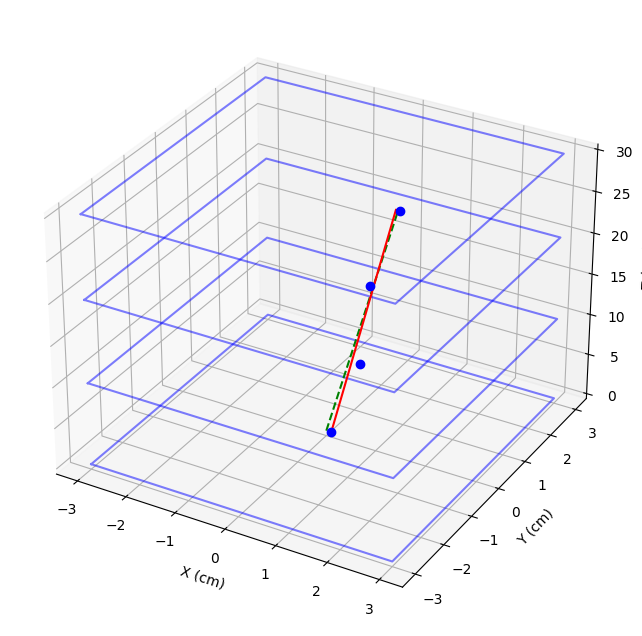

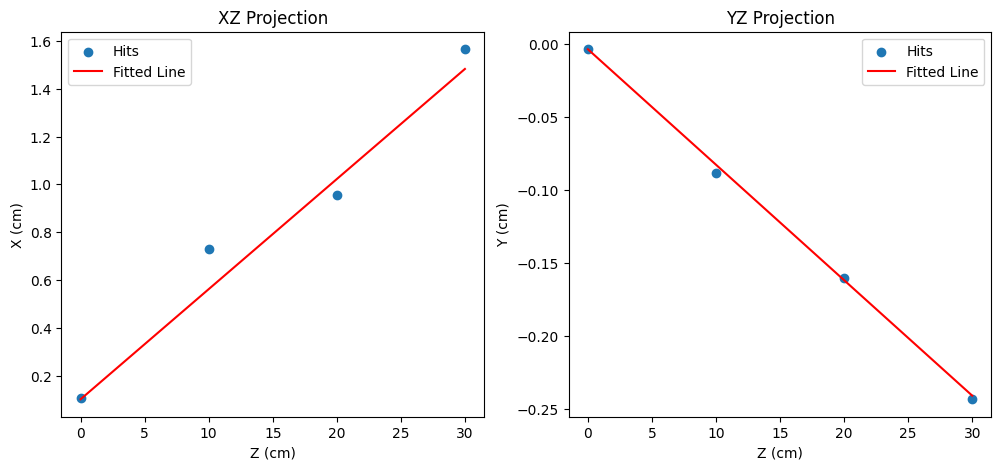

In [44]:
draw = True  # Set to True to enable plotting

sensors = [StsSensor((0,0,10*i), 6, 0, 0, (0.1, 0.01, 0.0)) for i in range(4)]

h_res_rho = [Histogram(Regular(100, -0.5, +0.5)) for _ in sensors]
if draw:
    # Plotting the sensors edges in 3D space
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    for sensor in sensors:
        ax.plot([sensor.x - sensor.dx/2, sensor.x + sensor.dx/2, sensor.x + sensor.dx/2, sensor.x - sensor.dx/2, sensor.x - sensor.dx/2],
                [sensor.y - sensor.dy/2, sensor.y - sensor.dy/2, sensor.y + sensor.dy/2, sensor.y + sensor.dy/2, sensor.y - sensor.dy/2],
                [sensor.z, sensor.z, sensor.z, sensor.z, sensor.z], color='blue', alpha=0.5)
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_zlabel('Z (cm)')



for p in particles:
    x_real, y_real, z_real = real_trajectory(p, sensors)
    measurement = measured_trajectory(p, sensors)

    # Fit the 3D line to the hits
    points_to_fit = [hit for hit in measurement if hit is not None]
    if len(points_to_fit) > 1:
        r0, tx, ty, residuals = fit_pca(points_to_fit)

        # Fill the histogram with residuals
        for i, res in enumerate(residuals):
            h_res_rho[i].fill(res)

        if draw:
            # Plot reatl trajectory
            ax.plot(x_real, y_real, z_real, 'g--', label='Real Trajectory')
            # building the fitted line
            z = np.linspace(points_to_fit[0][2], points_to_fit[-1][2], 100)
            x = points_to_fit[0][0] + tx * (z - points_to_fit[0][0])
            y = points_to_fit[0][1] + ty * (z - points_to_fit[0][1])

            ax.plot(x, y, z, 'r-', label='Fitted Line')
            # print(f"[{r0[0]:.4f}, {r0[1]:.4f}, {r0[2]:.4f}], [{tx:.4f}, {ty:.4f}, 1]\n{residuals}")
    else:
        print("Not enough hits to fit a line.")

    if draw:
        # Plotting the trajectory in 3D space
        for hit in points_to_fit:
            ax.plot([hit[0]], [hit[1]], [hit[2]], 'bo', label='Hit')
        ax.set_xlabel('X (cm)')
        ax.set_ylabel('Y (cm)')
        ax.set_zlabel('Z (cm)')

        # Plot XZ projection
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.scatter([p[2] for p in points_to_fit], [p[0] for p in points_to_fit], label='Hits')
        plt.plot(z, x, 'r-', label='Fitted Line')
        plt.xlabel('Z (cm)')
        plt.ylabel('X (cm)')
        plt.title('XZ Projection')
        plt.legend()

        # Plot YZ projection
        plt.subplot(1, 2, 2)
        plt.scatter([p[2] for p in points_to_fit], [p[1] for p in points_to_fit], label='Hits')
        plt.plot(z, y, 'r-', label='Fitted Line')
        plt.xlabel('Z (cm)')
        plt.ylabel('Y (cm)')
        plt.title('YZ Projection')
        plt.legend()



In [23]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from tqdm.notebook import tqdm
from functools import partial

def process_particles(particles, worker_id=0):
    h_res_rho_local = [Histogram(Regular(100, -0.5, +0.5)) for _ in sensors]
    trajectories = []
    measurements = []
    fit_results = []

    # for p in particles:
    for p in tqdm(particles, position=worker_id, desc=f"Worker {worker_id}", leave=False):
        trajectory = real_trajectory(p, sensors)
        measurement = measured_trajectory(p, sensors)
        trajectories.append(trajectory)
        measurements.append(measurement)

        points_to_fit = [hit for hit in measurement if hit is not None]
        if len(points_to_fit) > 1:
            r0, tx, ty, residuals = fit_least_squares(points_to_fit)
            fit_results.append((r0, tx, ty))

            # Fill the histogram with residuals
            for i, res in enumerate(residuals):
                h_res_rho_local[i].fill(res)

    return trajectories, measurements, fit_results, h_res_rho_local

def split_into_batches(data, n_batches):
    avg = len(data) // n_batches
    return [data[i * avg : (i + 1) * avg] for i in range(n_batches - 1)] + [data[(n_batches - 1) * avg:]]

n_of_threads = 4

batches = split_into_batches(particles, n_of_threads)

with ProcessPoolExecutor(max_workers=n_of_threads) as executor:
    futures = [
        executor.submit(process_particles, batch, i)
        for i, batch in enumerate(batches)
    ]
    for future in futures:
        try:
            trajectories, measurements, fit_results, residuals = future.result()
            for i in range(len(sensors)):
                h_res_rho[i] += residuals[i]
        except Exception as e:
            print(f"Error processing particle: {e}")

Error processing particle: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Error processing particle: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Error processing particle: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Error processing particle: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


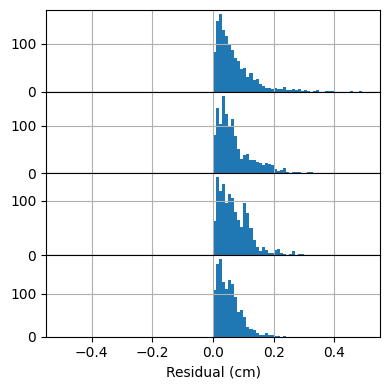

In [16]:
fig, axes = plt.subplots(len(h_res_rho), 1, figsize=(4, 1 * len(h_res_rho)), sharex=True, gridspec_kw={'hspace': 0})

for ax, hist in zip(axes, h_res_rho):
    ax.bar(hist.axes[0].centers, hist.values(), width=hist.axes[0].widths, align='center')
    ax.set_ylabel("")
    ax.grid(True)

axes[-1].set_xlabel("Residual (cm)")
plt.tight_layout()
plt.show()